In [1]:
import os
from sklearn.metrics import accuracy_score

import torch 
from torch import optim
import sys 
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp

from models.resnet import *
import socket


import datetime

## CIFAR-10の準備

In [2]:
data_path = "./data/"
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
img, label = cifar10_train[99]
img.shape

torch.Size([3, 32, 32])

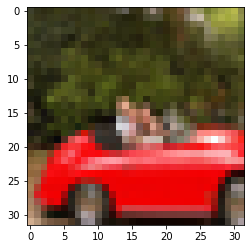

In [4]:
plt.imshow(img.permute(1,2,0))

## imageのaugumentationや正規化を実施した上で、再度cifar10を読み込む
- 学習データセットのチャネルごとの平均と標準偏差を用いて、学習データセット、テストデータセットの両方を正規化
- テストデータセットではaugumentation

In [5]:
train_img_stack = torch.stack([img_t for img_t, _ in cifar10_train])
mean_train = train_img_stack.view(3, -1).mean(dim=1)
std_train = train_img_stack.view(3, -1).std(dim=1)

In [6]:
transforms_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean_train, std_train)
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_train, std_train)
    ]
)


cifar10_train_dataset_aug = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms_train)
cifar10_test_dataset = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


## DataLoaderを定義する

In [7]:
cifar10_train_dataloader = DataLoader(cifar10_train_dataset_aug, batch_size=64, shuffle=True)
cifar10_test_dataloader = DataLoader(cifar10_test_dataset, batch_size=64, shuffle=False)

## 学習用のセットアップを行う
- モデルの定義
- 損失関数の定義
- Optimizerの定義

In [8]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

# モデルの定義
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 10)
resnet18.to(device=device)
# 損失関数の定義
loss_fn = nn.CrossEntropyLoss()
# Optimizerの定義
optimizer = optim.SGD(resnet18.parameters(), lr=1e-3)

In [9]:
def train_model(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs):
    model.train()
    for n_epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_dataloader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
    
        
        print(f'{datetime.datetime.now()} Epoch {n_epoch}, Training loss {loss_train / len(train_dataloader.dataset)}')
        eval_model(model, test_dataloader)
    return model


def eval_model(model, test_dataloader):
    model.eval()
    num_correct = 0
    for imgs, labels in test_dataloader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        num_correct += sum(outputs.argmax(axis=1) == labels).item()
    
    print(f"Accuracy {num_correct / len(test_dataloader.dataset)}")

## 学習を実施

In [ ]:
trained_model = train_model(resnet18, optimizer, loss_fn, cifar10_train_dataloader, cifar10_test_dataloader, 50)

2022-09-25 23:23:55.374997 Epoch 0, Training loss 0.030016513109207152
Accuracy 0.3783
2022-09-25 23:24:30.263080 Epoch 1, Training loss 0.027630066032409667
Accuracy 0.3546
2022-09-25 23:25:05.166485 Epoch 2, Training loss 0.02436999591588974
Accuracy 0.3847
2022-09-25 23:25:39.978515 Epoch 3, Training loss 0.02282743285894394
Accuracy 0.4173
2022-09-25 23:26:14.797814 Epoch 4, Training loss 0.021661278488636016
Accuracy 0.4864
2022-09-25 23:26:49.608673 Epoch 5, Training loss 0.020636741350889207
Accuracy 0.4246
2022-09-25 23:27:24.385447 Epoch 6, Training loss 0.019754293645620345
Accuracy 0.4822
2022-09-25 23:27:59.160464 Epoch 7, Training loss 0.018988832066059114
Accuracy 0.4835
2022-09-25 23:28:33.948881 Epoch 8, Training loss 0.018258316884040834
Accuracy 0.3638
2022-09-25 23:29:08.785098 Epoch 9, Training loss 0.017665082203149794
Accuracy 0.5599
2022-09-25 23:29:43.557656 Epoch 10, Training loss 0.017054505878686906
Accuracy 0.5683
2022-09-25 23:30:18.351506 Epoch 11, Trainin

## 複数GPUでの学習ループ

In [3]:
# 実験
def example(rank, world_size):
    # create default process group
    dist.init_process_group("gloo/", rank=rank, world_size=world_size)
    # create local model
    model = nn.Linear(10, 10).to(rank)
    # construct DDP model
    ddp_model = DDP(model, device_ids=[rank])
    # define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    # forward pass
    outputs = ddp_model(torch.randn(20, 10).to(rank))
    labels = torch.randn(20, 10).to(rank)
    # backward pass
    loss_fn(outputs, labels).backward()
    # update parameters
    optimizer.step()
    
def main():
    world_size = 2
    mp.spawn(example,
        args=(world_size,),
        nprocs=world_size,
        join=True)

In [5]:
os.environ["MASTER_ADDR"] = "spcc-a40g13"
os.environ["MASTER_PORT"] = "29500"
main()

Exception: process 1 terminated with exit code 1

In [ ]:
def train_model_ddp(
    rank, world_size, model, loss_fn, optimizer, train_dataloader, test_dataloader, n_epochs):
    # create default process group
    dist.init_process_group("nvcc", rank=rank, world_size=world_size)
    # construct DDP model
    ddp_model = DDP(model, device_ids=[rank])
    # define loss function and optimizer
    optimizer = optim.SGD(model.parameters(), lr=1e-2)
    
    for n_epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in train_dataloader:
            # forward pass
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

    # forward pass
    outputs = ddp_model(torch.randn(20, 10).to(rank))
    labels = torch.randn(20, 10).to(rank)
    # backward pass
    loss_fn(outputs, labels).backward()
    # update parameters
    optimizer.step()